In [1]:
!apt-get update && apt-get install -y python3-opencv 

Get:1 http://deb.debian.org/debian bullseye InRelease [116 kB]
Get:2 http://security.debian.org/debian-security bullseye-security InRelease [48.4 kB]
Get:3 http://deb.debian.org/debian bullseye-updates InRelease [44.1 kB]
Get:4 http://deb.debian.org/debian bullseye/main amd64 Packages [8183 kB]
Get:5 http://deb.debian.org/debian bullseye-updates/main amd64 Packages [17.5 kB]
Get:6 http://security.debian.org/debian-security bullseye-security/main amd64 Packages [245 kB]
Fetched 8653 kB in 1s (7656 kB/s)                        
Reading package lists... Done
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  adwaita-icon-theme at-spi2-core dbus-user-session dconf-gsettings-backend
  dconf-service dmsetup gdal-data glib-networking glib-networking-common
  glib-networking-services gsettings-desktop-schemas gstreamer1.0-plugins-base
  gtk-update-icon-cache i965-va-driver intel-media-va-driver

In [2]:
%pip install diffusers==0.20.0 \
  pillow==10.0.0 \
  torch==2.0.1 \
  opencv-python==4.8.0.76 \
  torchvision==0.15.2 \
  controlnet-aux==0.0.6 \
  accelerate==0.21.0 \
  transformers==4.31.0

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
  Obtaining dependency information for diffusers==0.20.0 from https://files.pythonhosted.org/packages/24/4a/b45557513dfcfb6d69e5c138325a0d7431943792b662e482dcd886c11bb4/diffusers-0.20.0-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 204.0 MB/s eta 0:00:0000:0100:01
  Obtaining dependency information for opencv-python==4.8.0.76 from https://files.pythonhosted.org/packages/f5/d0/2e455d894ec0d6527e662ad55e70c04f421ad83a6fd0a54c3dd73c411282/opencv_python-4.8.0.76-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 269.9 MB/s eta 0:00:00
  Obtaining dependency information for controlnet-aux==0.0.6 from https://files.pythonhosted.org/packages/48/89/a9c1d8fea2e1266eed9ea505215efa330de3385bee618326252c62edbccd/controlnet_aux-0.0.6-py3-none-any.whl.metadata
  Obtaining dependency information for accelerate==0.21.0 fr

![](img/meredith.png)

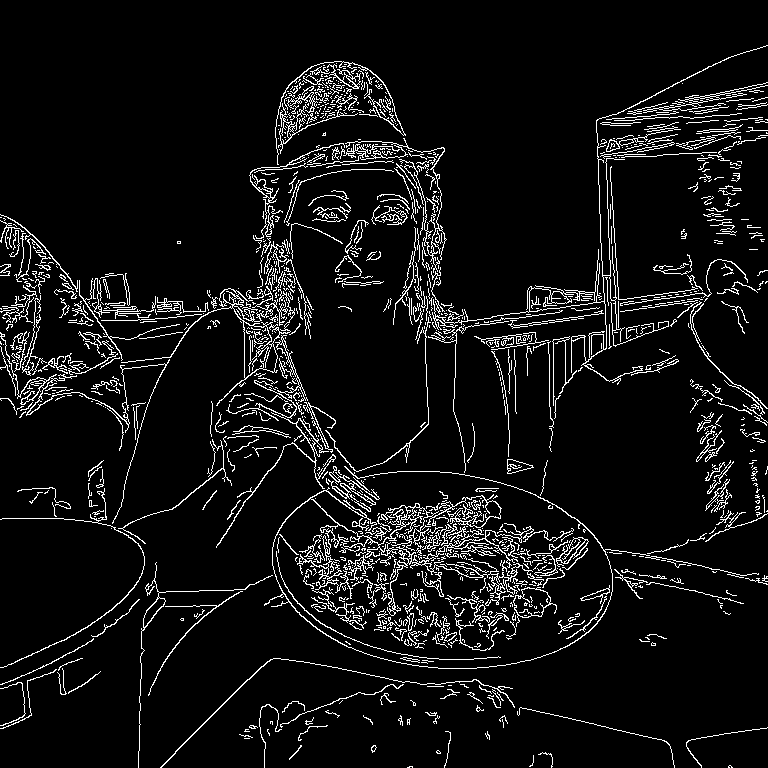

In [3]:
from diffusers import StableDiffusionControlNetPipeline
#from diffusers.utils import load_image
from diffusers.utils.testing_utils import load_image

image = load_image("img/meredith.png")

# Render the canny edge map for this particular image
import cv2
from PIL import Image
import numpy as np

image = np.array(image)

low_threshold = 100
high_threshold = 200

image = cv2.Canny(image, low_threshold, high_threshold)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)
canny_image = Image.fromarray(image)

canny_image.save("./output/canny_image.png")

canny_image

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


  0%|          | 0/20 [00:00<?, ?it/s]

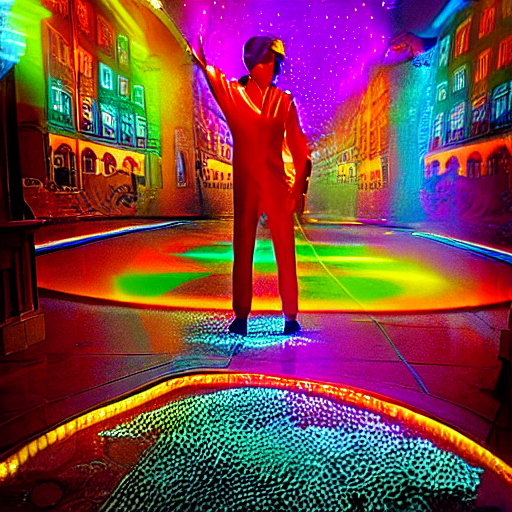

In [22]:
from diffusers import StableDiffusionControlNetPipeline
from diffusers import ControlNetModel
import torch

canny = ControlNetModel.from_pretrained(
    "lllyasviel/sd-controlnet-canny", 
)

sd_pipe = StableDiffusionControlNetPipeline.from_pretrained(      
    "runwayml/stable-diffusion-v1-5", 
    controlnet=canny, 
)

generator = torch.manual_seed(0)

out_image = sd_pipe(
    "disco dancer with colorful lights", 
    num_inference_steps=20, 
    generator=generator, 
    image=canny_image
).images[0]

out_image.save("./output/out_image.png")

out_image

# Canny Image - Background
![](img/landscape-sr.png)

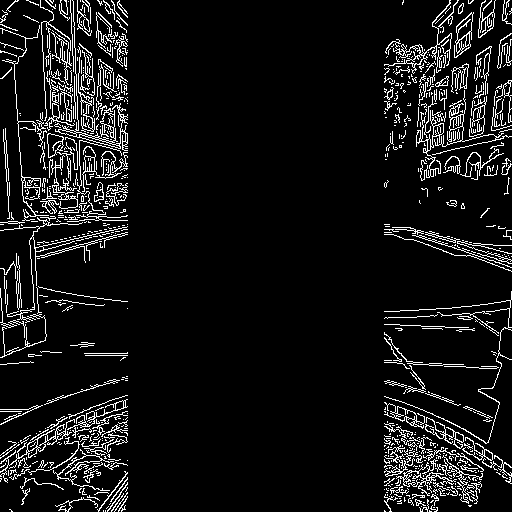

In [15]:
from PIL import Image
import cv2
import numpy as np
#from diffusers.utils import load_image
from diffusers.utils.testing_utils import load_image

canny_image = load_image("img/landscape-sr.png")
canny_image = np.array(canny_image)
low_threshold = 100
high_threshold = 200
canny_image = cv2.Canny(canny_image, 
  low_threshold, 
  high_threshold)


# zero out middle columns of image where pose will be overlayed
zero_start = canny_image.shape[1] // 4
zero_end = zero_start + canny_image.shape[1] // 2
canny_image[:, zero_start:zero_end] = 0
canny_image = canny_image[:, :, None]
canny_image = np.concatenate([canny_image, canny_image, canny_image], axis=2)
canny_image = Image.fromarray(canny_image)

canny_image.save("./output/canny_image_masked.png")

canny_image

# Openpose - Person

![](img/tommy_blue_tongue.png)

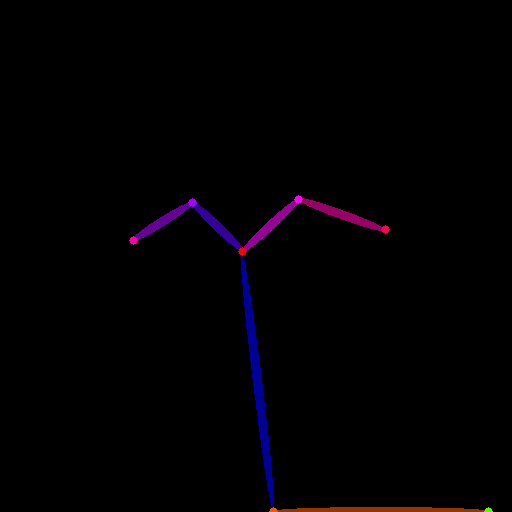

In [16]:
from controlnet_aux import OpenposeDetector
#from diffusers.utils import load_image
from diffusers.utils.testing_utils import load_image

openpose = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")

openpose_image = load_image("img/tommy_blue_tongue.png")
#"https://dsoaws.s3.amazonaws.com/gaia/11_multimodal/img/person.png"

openpose_image = openpose(openpose_image)

openpose_image.save("./output/openpose.png")

openpose_image

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


  0%|          | 0/20 [00:00<?, ?it/s]

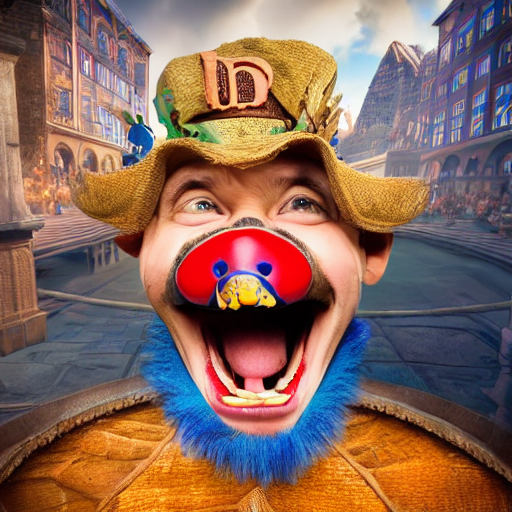

In [17]:
from diffusers import StableDiffusionControlNetPipeline
from diffusers import ControlNetModel
import torch

controls = [      
  ControlNetModel\
    .from_pretrained("lllyasviel/sd-controlnet-openpose",  
),
  ControlNetModel\
    .from_pretrained("lllyasviel/sd-controlnet-canny", 
)
]
pipe = StableDiffusionControlNetPipeline\
  .from_pretrained(
    "runwayml/stable-diffusion-v1-5", 
    controlnet=controls, 
)
prompt = "boy giant pig head in a fantasy landscape, best quality"
negative_prompt = "monochrome, lowres, bad anatomy, worst quality, low quality"
generator = torch.Generator(device="cpu").manual_seed(1)
images = [openpose_image, canny_image]

image = pipe(
    prompt,
    images,
    num_inference_steps=20,
    generator=generator,
    negative_prompt=negative_prompt,
    controlnet_conditioning_scale=[1.0, 0.8],
).images[0]

image.save("./output/output.png")

image 